### In this notebook, I have added the 1D CNN blocks along with LSTM blocks.
LSTMs are considered to be suitable for text classification since, they have the ability to learn long-term dependencies, which is made possible by their memory cell
CNNs possess the ability to learn spatial relationships and train faster than LSTMs.

##Step 1: Load the data from google drive and import necessary packages

In [ ]:
!cp drive/My\ Drive/finaldata.csv /content

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
data = pd.read_csv('finaldata.csv')

In [ ]:
data.head()

,Unnamed: 0,Product Name,Description,Image,Category
0,0,Alisha Solid Women's Cycling Shorts,key features alisha solid women s cycling shor...,"[""http://img5a.flixcart.com/image/short/u/4/a/...",Clothing
1,1,FabHomeDecor Fabric Double Sofa Bed,fabhomedecor fabric double sofa bed finish col...,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",Furniture
2,2,AW Bellies,key features aw bellies sandals wedges heel ca...,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",Footwear
3,3,Alisha Solid Women's Cycling Shorts,key features alisha solid women s cycling shor...,"[""http://img5a.flixcart.com/image/short/6/2/h/...",Clothing
4,6,Alisha Solid Women's Cycling Shorts,key features alisha solid women s cycling shor...,"[""http://img6a.flixcart.com/image/short/p/j/z/...",Clothing


In [ ]:
data.drop('Unnamed: 0',axis = 1,inplace = True)

##Step 2: Load data manipulation libraries and Label Encode the categories

Data is split in training and validation sets in a 80:20 split

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
le = LabelEncoder()
data['Category'] = le.fit_transform(data['Category'])

In [ ]:
trainx,testx,trainy,testy = train_test_split(data['Description'],data['Category'],stratify = data['Category'])

##Step 3: Tokenize the input sentences and pad the resulting sequences

Tokenization is necessary to convert words into correspondind ids and vectorizing text since, all DL computations require mathematical inputs to operate upon

Sequences are padded to a maximum length of 100 (to reduce computation). It is necessary since, all input sentences are of varying length and LSTM would require a uniform input shape

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tok = Tokenizer(num_words = 6000)
tok.fit_on_texts(trainx)

In [ ]:
train_sent = tok.texts_to_sequences(trainx)

In [ ]:
train_sent = pad_sequences(train_sent,maxlen = 100)

In [ ]:
test_sent = tok.texts_to_sequences(testx)

In [ ]:
test_sent = pad_sequences(test_sent,maxlen = 100)

##Step 4: Create the model using Sequential API


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dropout,Dense,LSTM,Bidirectional,Conv1D,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

Storing category names corresponding to their encoded labels

In [ ]:
n = data['Category'].unique().max()+1

In [ ]:
label_names = []
for i in range(n):
  label_names.append(le.inverse_transform(np.array(i).reshape(-1,1))[0])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
label_names

['Automotive',
 'Baby Care',
 'Bags, Wallets & Belts',
 'Beauty and Personal Care',
 'Cameras & Accessories',
 'Clothing',
 'Computers',
 'Eyewear',
 'Footwear',
 'Furniture',
 'Health & Personal Care Appliances',
 'Home Decor & Festive Needs',
 'Home Furnishing',
 'Home Improvement',
 'Jewellery',
 'Kitchen & Dining',
 'Mobiles & Accessories',
 'Pens & Stationery',
 'Sports & Fitness',
 'Tools & Hardware',
 'Toys & School Supplies',
 'Watches']

One hot encoding target labels

In [ ]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(trainy)

In [ ]:
test_labels = to_categorical(testy)

####Define the model

To visualize model:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim = 6000,output_dim = 50,input_length=100))
model.add(Conv1D(32,3,activation = 'relu'))
model.add(Conv1D(64,3,activation = 'relu'))
model.add(Conv1D(128,3,activation = 'relu'))
model.add(GlobalAveragePooling1D())
#model.add(Bidirectional(LSTM(32,return_sequences=True)))
#model.add(Bidirectional(LSTM(64,return_sequences=False)))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(256,activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(22,activation = 'softmax'))

Defining Callbacks to save the best model and reduce learning rate when loss stops to decay

In [ ]:
checks = ModelCheckpoint('best.h5',monitor = 'val_loss',save_best_only=True)
lrsched = ReduceLROnPlateau(factor = 0.5,patience = 2)

Defining f1 score metrics since, the class labels are imbalanced and accuracy is not a great measure to evaluate the model performance

In [ ]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Compiling the model using categorical crossentopy (log loss) and Adamax optimizer

In [ ]:
model.compile(loss = 'categorical_crossentropy',optimizer = Adamax(),metrics = ['accuracy',f1_m])

Fit the model on data for 10 epochs

In [ ]:
hist = model.fit(train_sent,train_labels,validation_data = (test_sent,test_labels),callbacks=[lrsched,checks],batch_size=64,epochs = 10)

Epoch 1/10
230/230 [==============================] - 5s 15ms/step - loss: 2.3609 - accuracy: 0.3418 - f1_m: 0.1960 - val_loss: 1.5594 - val_accuracy: 0.5315 - val_f1_m: 0.6129
Epoch 2/10
230/230 [==============================] - 3s 11ms/step - loss: 1.4763 - accuracy: 0.5581 - f1_m: 0.6268 - val_loss: 1.2107 - val_accuracy: 0.6170 - val_f1_m: 0.6418
Epoch 3/10
230/230 [==============================] - 3s 12ms/step - loss: 1.1427 - accuracy: 0.6334 - f1_m: 0.6785 - val_loss: 0.9651 - val_accuracy: 0.6921 - val_f1_m: 0.7409
Epoch 4/10
230/230 [==============================] - 3s 12ms/step - loss: 0.9140 - accuracy: 0.7093 - f1_m: 0.7424 - val_loss: 0.8205 - val_accuracy: 0.7709 - val_f1_m: 0.7635
Epoch 5/10
230/230 [==============================] - 3s 13ms/step - loss: 0.7572 - accuracy: 0.7623 - f1_m: 0.7775 - val_loss: 0.6996 - val_accuracy: 0.8094 - val_f1_m: 0.8175
Epoch 6/10
230/230 [==============================] - 3s 13ms/step - loss: 0.6170 - accuracy: 0.8172 - f1_m: 0.8223

The validation loss seems to decay further, training for additional 20 epochs

In [ ]:
hist2 = model.fit(train_sent,train_labels,validation_data = (test_sent,test_labels),callbacks=[lrsched,checks],batch_size=64,epochs = 30,initial_epoch = 10)

Epoch 11/30
230/230 [==============================] - 3s 13ms/step - loss: 0.3148 - accuracy: 0.9118 - f1_m: 0.9179 - val_loss: 0.4798 - val_accuracy: 0.8876 - val_f1_m: 0.8942
Epoch 12/30
230/230 [==============================] - 3s 13ms/step - loss: 0.2809 - accuracy: 0.9184 - f1_m: 0.9250 - val_loss: 0.4579 - val_accuracy: 0.8931 - val_f1_m: 0.9006
Epoch 13/30
230/230 [==============================] - 3s 13ms/step - loss: 0.2563 - accuracy: 0.9286 - f1_m: 0.9328 - val_loss: 0.4586 - val_accuracy: 0.9008 - val_f1_m: 0.9063
Epoch 14/30
230/230 [==============================] - 3s 13ms/step - loss: 0.2394 - accuracy: 0.9302 - f1_m: 0.9352 - val_loss: 0.4543 - val_accuracy: 0.9006 - val_f1_m: 0.9087
Epoch 15/30
230/230 [==============================] - 3s 13ms/step - loss: 0.2140 - accuracy: 0.9391 - f1_m: 0.9426 - val_loss: 0.4637 - val_accuracy: 0.9055 - val_f1_m: 0.9110
Epoch 16/30
230/230 [==============================] - 3s 13ms/step - loss: 0.1950 - accuracy: 0.9454 - f1_m: 

##Step 5: Results and Model Evaluation

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
preds = model.predict(test_sent)

In [ ]:
preds = preds.argmax(axis = 1)

In [ ]:
preds.shape

(4901,)

####Classification report for validation and training sets

It is observed that the model has achieved decent f1 score, with minority classes such as Eyewear having low score due to less amount of data

In [ ]:
 print(classification_report(test_labels.argmax(axis = 1),preds,target_names=label_names))

                                   precision    recall  f1-score   support

                       Automotive       0.96      0.96      0.96       254
                        Baby Care       0.80      0.69      0.74       121
            Bags, Wallets & Belts       0.63      0.65      0.64        66
         Beauty and Personal Care       0.89      0.83      0.85       178
            Cameras & Accessories       0.63      0.57      0.60        21
                         Clothing       0.99      0.99      0.99      1549
                        Computers       0.78      0.83      0.80       145
                          Eyewear       0.00      0.00      0.00        12
                         Footwear       0.92      0.94      0.93       309
                        Furniture       0.82      0.91      0.86        45
Health & Personal Care Appliances       0.00      0.00      0.00        11
       Home Decor & Festive Needs       0.87      0.88      0.87       233
                  Home F

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(train_labels.argmax(axis = 1),model.predict(train_sent).argmax(axis = 1),target_names=label_names))

                                   precision    recall  f1-score   support

                       Automotive       0.99      1.00      0.99       760
                        Baby Care       0.96      0.81      0.88       362
            Bags, Wallets & Belts       0.91      0.93      0.92       199
         Beauty and Personal Care       0.95      0.96      0.95       534
            Cameras & Accessories       0.86      0.67      0.75        64
                         Clothing       1.00      1.00      1.00      4648
                        Computers       0.96      0.94      0.95       435
                          Eyewear       1.00      0.29      0.44        35
                         Footwear       0.99      0.99      0.99       928
                        Furniture       0.90      0.99      0.94       137
Health & Personal Care Appliances       0.00      0.00      0.00        32
       Home Decor & Festive Needs       0.98      0.99      0.98       699
                  Home F

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting ROC Curve for the predicted result

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

In [ ]:
fpr,tpr,thresh = dict(),dict(),dict()

In [ ]:
test_probs = model.predict_proba(test_sent)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


In [ ]:
for i in range(n):    
    fpr[i], tpr[i], thresh[i] = roc_curve(testy, test_probs[:,i], pos_label=i)

In [ ]:
import matplotlib.pyplot as plt

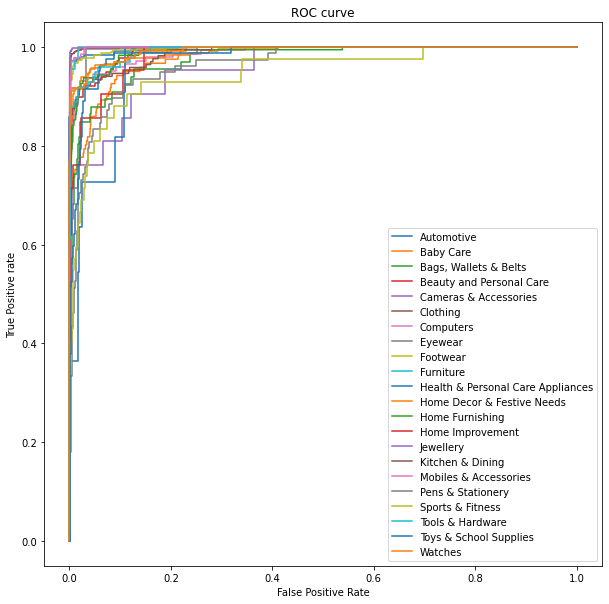

In [ ]:
plt.figure(figsize = (10,10))
for i in range(n):
  plt.plot(fpr[i],tpr[i],label = label_names[i])
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

Plotting Confusion Matrix for training and validation sets

Some misclassifications can be seen

In [ ]:
cm = confusion_matrix(test_labels.argmax(axis = 1),preds)

In [ ]:
import seaborn as sn

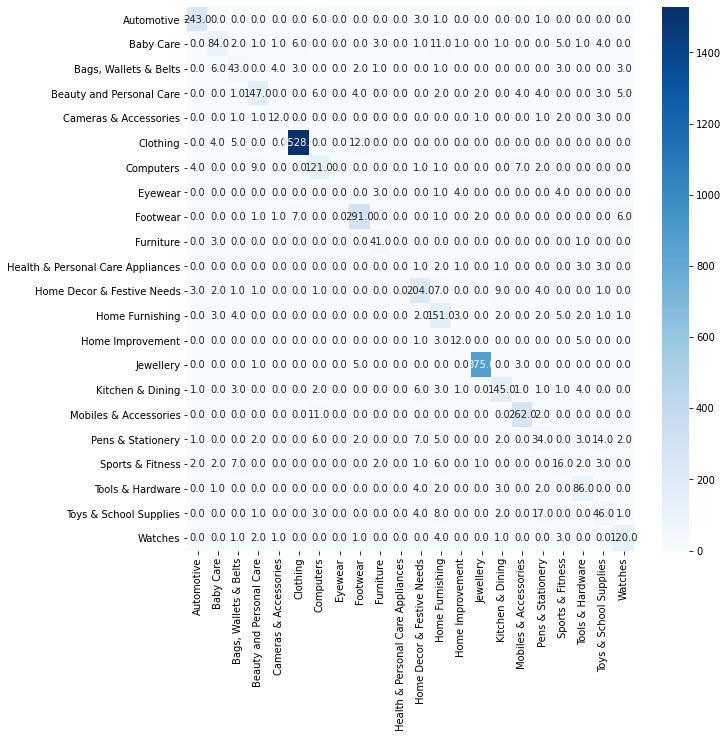

In [ ]:
plt.figure(figsize=(10,10))
sn.heatmap(cm,cmap = 'Blues',annot = True,fmt = '.1f',xticklabels = label_names,yticklabels=label_names)

In [ ]:
cm = confusion_matrix(train_labels.argmax(axis = 1),model.predict(train_sent).argmax(axis = 1))

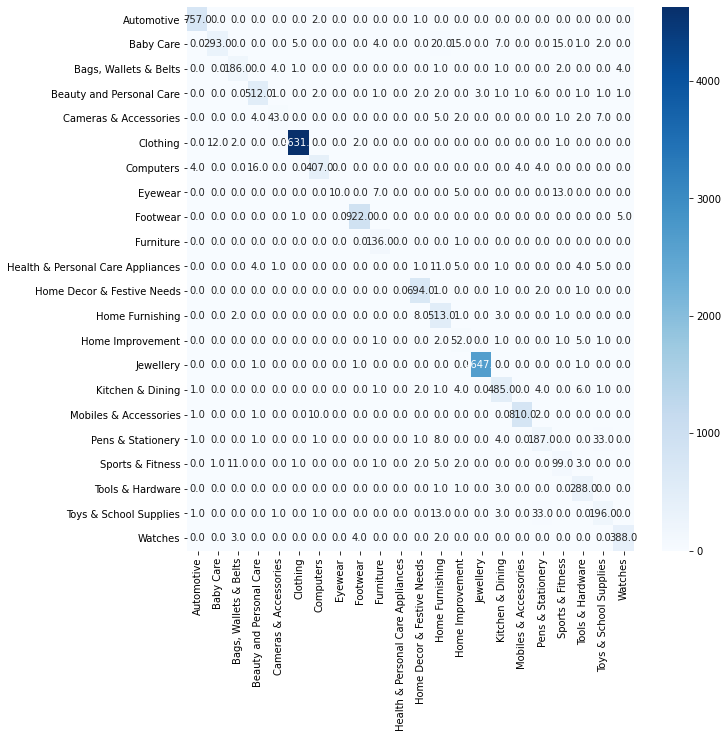

In [ ]:
plt.figure(figsize=(10,10))
sn.heatmap(cm,cmap = 'Blues',annot = True,fmt = '.1f',xticklabels = label_names,yticklabels=label_names)

####Plotting Model loss and accuracy curves

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

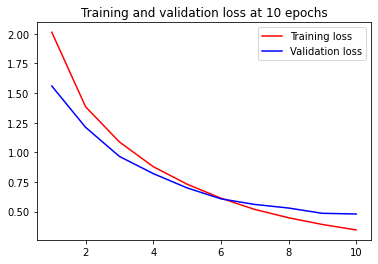

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss at 10 epochs')
plt.legend()

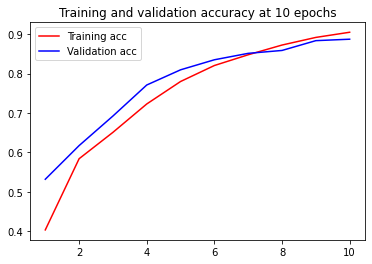

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy at 10 epochs')
plt.legend()

In [ ]:
acc = hist.history['accuracy']+hist2.history['accuracy']
val_acc = hist.history['val_accuracy']+hist2.history['val_accuracy']
loss = hist.history['loss']+hist2.history['loss']
val_loss = hist.history['val_loss']+hist2.history['val_loss']

epochs = range(1, len(acc) + 1)

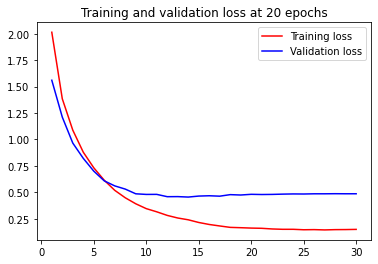

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss at 20 epochs')
plt.legend()

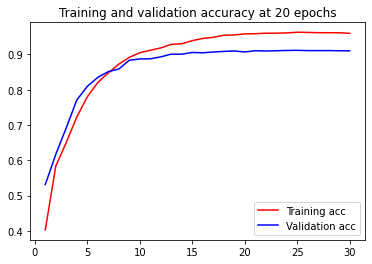

In [ ]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy at 20 epochs')
plt.legend()

##Step 6: Save model weights to Google Drive

In [ ]:
!cp /content/best.h5 drive/My\ Drive/cnn.h5

##Conclusion:

The LSTM model performed decently in predicting the product categories. The model did not overfit, indicated by concurrent loss curves.

The model may perform better with more data since, the available data is scarce and categories are severely imbalanced

##Future Scope:

1. Combine both LSTM and CNN
2. Use Transformers
3. Lemmatize or Stem Data
4. Scrape more data
5. Hyperparameter tuning

###References:

1. F1 metrics in keras: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
2. Plotting ROC Curve: analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/